In [57]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 10), dpi=100, facecolor='w', edgecolor='k')
import pandas as pd
from scipy.stats import zscore, norm
import matplotlib.pyplot as plt


<Figure size 1500x1000 with 0 Axes>

In [3]:
pca_per_pathway = pd.read_csv('../data/pca_per_pathway.csv', index_col=0)

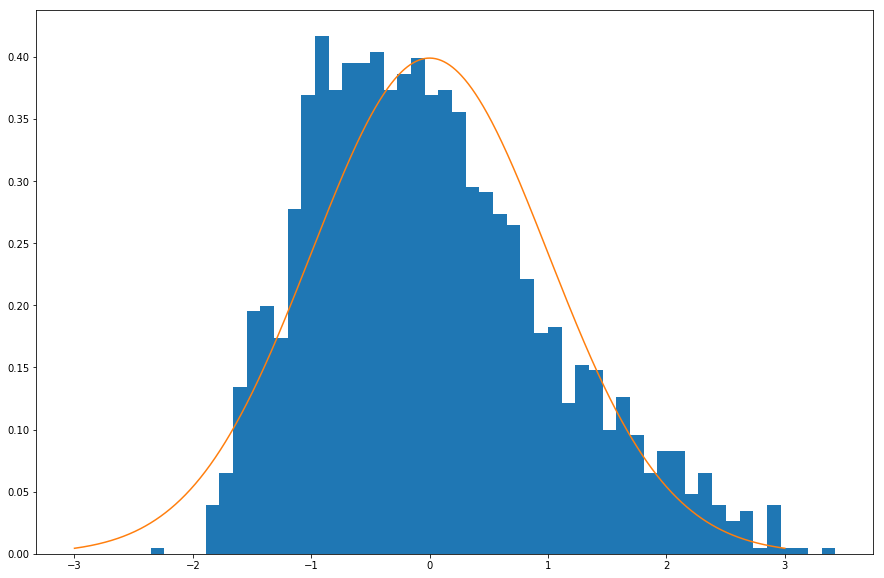

In [84]:
def null_testing(pathwayname):
    ##Generate Zscores
    cell_cycle = zscore(pca_per_pathway[pathwayname])
    zscore2 = zscore(cell_cycle)

    ## Plot distribution of pathway eigenvalues
    plt.figure(figsize=(15, 10))
    plt.hist(cell_cycle, bins=50, density=True)

    ##Normal distribution
    x = np.linspace(mu -3*sigma, mu+ 3*sigma, 1000)
    plt.plot(x, norm.pdf(x, 0, 1))
    plt.savefig('CellCycleDist.png')
    plt.show()
    
null_testing('Cell Cycle')
